**Author:** David Salas,MBA 
**Date:** July 2025  
**Description:**  
This project automates a full Discounted Cash Flow (DCF) valuation using financial data from the Financial Modeling Prep API. It calculates key financial metrics including:

- Free Cash Flow (FCF) Projections
- Cost of Equity and Debt
- WACC (Weighted Average Cost of Capital)
- Terminal Value
- Net Present Value (NPV)

**Dependencies:**  
- Python 3.x  
- `requests`, `pandas`, `matplotlib`

**API Used:**  
- [Financial Modeling Prep](https://financialmodelingprep.com/)

In [76]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time 
import json
import requests

In [170]:


API_KEY = "R2cXGWWQBtHBIqEhlmFDz1hUkEhN0wSY"  # Your correct API key
BASE_URL = "https://financialmodelingprep.com/api/v3"

ticker = "UNH"  # Change ticker here

def get_cash_flow_statements(ticker, years=5):
    url = f"{BASE_URL}/cash-flow-statement/{ticker}?limit={years}&apikey={API_KEY}"
    response = requests.get(url)
    data = response.json()

    if not isinstance(data, list) or len(data) == 0:
        print(f"❌ No Data for cash flows {ticker}.")
        return None

    symbol_from_api = data[0].get('symbol', 'N/A')
    if symbol_from_api != ticker.upper():
        print(f"⚠️ Warning: we need '{ticker.upper()}' But API returned '{symbol_from_api}'.")

    print(f"✅ Data for cash flows obtained: {symbol_from_api}")

    fcf_list = []
    for year_data in data:
        if 'freeCashFlow' in year_data:
            fcf_list.append(year_data['freeCashFlow'])

    return fcf_list[::-1]  # Chronological order

# Get cash flow data
fcf_data = get_cash_flow_statements(ticker)
print(fcf_data)

✅ Data for cash flows obtained: UNH
[20123000000, 19889000000, 23404000000, 25682000000, 20705000000]


In [171]:
#  CAGR

def calculate_cagr(fcf_list):
    if not fcf_list or len(fcf_list) < 2:
        print("❌ Need at least 2 years to calculate CAGR.")
        return None

    start = fcf_list[0]
    end = fcf_list[-1]
    n = len(fcf_list) - 1

    if start <= 0:
        print("❌ The initial FCF must be positive to calculate CAGR.")
        return None

    cagr = (end / start) ** (1 / n) - 1
    print(f"📈 CAGR calculated: {cagr:.4f} ({cagr*100:.2f}%)")
    return cagr

# Full execution
fcf_data = get_cash_flow_statements(ticker)
if fcf_data:
    cagr = calculate_cagr(fcf_data)

✅ Data for cash flows obtained: UNH
📈 CAGR calculated: 0.0072 (0.72%)


In [172]:
fcf_data = get_cash_flow_statements(ticker)
if fcf_data:
    cagr = calculate_cagr(fcf_data)

    # Ask user to choose between CAGR or manual input
    if cagr is not None:
        use_cagr = input("Use calculated CAGR? (yes/no): ").strip().lower()
        if use_cagr == "yes":
            growth_rate = cagr
        else:
            growth_rate = float(input("Enter your manual annual growth rate (e.g., 0.06 for 6%): "))
    else:
        # Fallback: only manual input
        growth_rate = float(input("Enter your manual annual growth rate (e.g., 0.06 for 6%): "))

    print(f"✅ Using Growth Rate: {growth_rate:.2%}")

    # Save this to use in your DCF next
    initial_fcf = fcf_data[-1]  # Most recent year FCF
else:
    print("❌ Could not fetch FCF data. Check the ticker or API.")

✅ Data for cash flows obtained: UNH
📈 CAGR calculated: 0.0072 (0.72%)


Use calculated CAGR? (yes/no):  yes


✅ Using Growth Rate: 0.72%


In [175]:
#BETA
def get_beta(ticker):
    url = f"{BASE_URL}/profile/{ticker}?apikey={API_KEY}"
    response = requests.get(url)
    data = response.json()
    try:
        beta = data[0]['beta']
        return beta
    except (KeyError, IndexError):
        print("❌ Could not retrieve the beta.")
        return None
    

In [176]:
def project_fcf_from_ltm(ltm_fcf, growth_rate, years=5):
    projections = []
    fcf = ltm_fcf
    for _ in range(years):
        fcf *= (1 + growth_rate)
        projections.append(fcf)
    return projections

In [177]:
# Step 2: Calculate the Cost of Equity (CAPM)
def calculate_cost_of_equity(beta, risk_free_rate=0.043, market_premium=0.05):
    return risk_free_rate + beta * market_premium

In [178]:
beta = get_beta(ticker)
if beta is not None:
    cost_of_equity = calculate_cost_of_equity(beta)
    print(f"📊 Beta: {beta:.2f}")
    print(f"💰 Cost of Equity (Re): {cost_of_equity:.4f} ({cost_of_equity*100:.2f}%)")
else:
    print("Could not calculate the cost of equity.")

📊 Beta: 0.45
💰 Cost of Equity (Re): 0.0657 (6.57%)


In [179]:
# Cost of debt

def estimate_cost_of_debt(ticker):
    # Get income statement
    url_income = f"{BASE_URL}/income-statement/{ticker}?limit=1&apikey={API_KEY}"
    income_response = requests.get(url_income)
    income_data = income_response.json()

    # Get balance sheet
    url_balance = f"{BASE_URL}/balance-sheet-statement/{ticker}?limit=1&apikey={API_KEY}"
    balance_response = requests.get(url_balance)
    balance_data = balance_response.json()

    try:
        interest_expense = abs(income_data[0]['interestExpense'])  # Can be negative
        total_debt = balance_data[0]['totalDebt']
        cost_of_debt = interest_expense / total_debt

        print(f"💵 Interest Expense: ${interest_expense:,.0f}")
        print(f"💰 Total Debt: ${total_debt:,.0f}")
        print(f"📉 Cost of Debt for {ticker.upper()}: {cost_of_debt:.2%}")

        return cost_of_debt, total_debt  # Return both
    except (KeyError, IndexError, ZeroDivisionError) as e:
        print("❌ Error calculating cost of debt:", e)
        return None, None

In [180]:
cost_of_debt, total_debt = estimate_cost_of_debt(ticker)

💵 Interest Expense: $3,906,000,000
💰 Total Debt: $76,904,000,000
📉 Cost of Debt for UNH: 5.08%


In [181]:
def get_market_cap_and_shares(ticker):
    url = f"{BASE_URL}/profile/{ticker}?apikey={API_KEY}"
    response = requests.get(url)

    try:
        data = response.json()
        profile = data[0]

        market_cap = profile.get("mktCap")
        shares_outstanding = profile.get("sharesOutstanding")
        price = profile.get("price")

        if shares_outstanding is None and market_cap and price:
            shares_outstanding = market_cap / price
            print("⚠️ Shares Outstanding estimated manually.")

        print(f"📊 Ticker: {ticker.upper()}")
        print(f"💼 Market Cap: ${market_cap:,.2f}")
        print(f"📈 Shares Outstanding: {shares_outstanding:,.0f}")
        print(f"💼 Price: ${price:,.2f}")

        return market_cap, shares_outstanding, price  # Modified to return price

    except Exception as e:
        print("❌ Error obtaining data:", e)
        return None, None, None

# Fetch data
market_cap, shares_outstanding, price = get_market_cap_and_shares(ticker)



⚠️ Shares Outstanding estimated manually.
📊 Ticker: UNH
💼 Market Cap: $257,241,318,360.00
📈 Shares Outstanding: 907,140,000
💼 Price: $283.57


In [182]:
def calculate_wacc(market_cap, total_debt, cost_of_equity, cost_of_debt, tax_rate=0.21):
    """Calculates the WACC using the provided inputs"""
    if market_cap is None or total_debt is None:
        print("❌ Error: Market cap or total debt is not defined.")
        return None

    V = market_cap + total_debt  # Total firm value
    E = market_cap               # Market value of equity
    D = total_debt               # Value of debt

    wacc = (E / V) * cost_of_equity + (D / V) * cost_of_debt * (1 - tax_rate)
    return wacc

# 👇 Calculate WACC
wacc = calculate_wacc(market_cap, total_debt, cost_of_equity, cost_of_debt)
if wacc is not None:
    print(f"✅ WACC for {ticker.upper()}: {wacc:.2%}")

✅ WACC for UNH: 5.98%


In [183]:

# Step 2: Calculate the present value of each FCF
"""
    Calculates the enterprise value using DCF with FCF projections,
    WACC, and perpetual growth rate.
"""
def calculate_enterprise_value(initial_fcf, growth_rate, wacc, perpetual_growth, years=5):
    projected_fcf = [initial_fcf * ((1 + growth_rate) ** i) for i in range(1, years + 1)]
    discounted_fcf = [
        fcf / ((1 + wacc) ** i)
        for i, fcf in enumerate(projected_fcf, start=1)
    ]
    pv_fcf = sum(discounted_fcf)
    final_fcf = projected_fcf[-1]
    terminal_value = (final_fcf * (1 + perpetual_growth)) / (wacc - perpetual_growth)
    discounted_terminal_value = terminal_value / ((1 + wacc) ** years)
    enterprise_value = pv_fcf + discounted_terminal_value
    return enterprise_value, projected_fcf, terminal_value


if fcf_data and growth_rate is not None and wacc is not None:
    initial_fcf = fcf_data[-1]  # Most recent FCF
    projection_years = 5

    enterprise_value, fcf_proj, terminal_value = calculate_enterprise_value(
        initial_fcf=initial_fcf,
        growth_rate=growth_rate,
        wacc=wacc,
        perpetual_growth=perpetual_growth,
        years=projection_years
    )

    print("\n📈 Projected FCFs for the next 5 years:")
    for i, fcf in enumerate(fcf_proj, start=1):
        print(f"Year {i}: ${fcf:,.2f}")

    print(f"\n🏁 Terminal Value calculated: ${terminal_value:,.2f}")
    print(f"📊 Year 5 Cash Flow: ${fcf_proj[-1]:,.2f}")
    print(f"💰 Enterprise Value (DCF): ${enterprise_value:,.2f}")

else:
    print("❌ Missing data: Ensure you have FCF data, growth rate, and WACC calculated.")




📈 Projected FCFs for the next 5 years:
Year 1: $20,853,111,325.90
Year 2: $21,002,282,152.64
Year 3: $21,152,520,059.26
Year 4: $21,303,832,679.02
Year 5: $21,456,227,699.79

🏁 Terminal Value calculated: $742,223,374,206.55
📊 Year 5 Cash Flow: $21,456,227,699.79
💰 Enterprise Value (DCF): $644,308,206,871.46


In [184]:
# Sum of Year 5 cash flow + terminal value
year5_flow_plus_terminal = fcf_proj[-1] + terminal_value
print(f"🔢 Year 5 + Terminal Value Sum: ${year5_flow_plus_terminal:,.2f}")



🔢 Year 5 + Terminal Value Sum: $763,679,601,906.33


In [185]:
# Build the list of cash flows for NPV, using the adjusted Year 5 cash flow
flows_for_npv = fcf_proj[:-1] + [year5_flow_plus_terminal]

# Calculate NPV by discounting each cash flow with the WACC
years = range(1, len(flows_for_npv) + 1)
npv = sum(flow / ((1 + wacc) ** t) for flow, t in zip(flows_for_npv, years))

print(f"\n💰 Net Present Value (NPV): ${npv:,.2f}")


💰 Net Present Value (NPV): $644,308,206,871.46


In [186]:
def get_cash_and_equivalents(ticker):
    url = f"{BASE_URL}/balance-sheet-statement/{ticker}?limit=1&apikey={API_KEY}"
    response = requests.get(url)
    
    try:
        data = response.json()
        if isinstance(data, list) and len(data) > 0:
            cash = data[0].get("cashAndCashEquivalents", None)
            if cash is not None:
                print(f"💵 Cash & Equivalents for {ticker.upper()}: ${cash:,.2f}")
                return cash
            else:
                print("❌ The 'cashAndCashEquivalents' field was not found.")
        else:
            print("❌ Could not retrieve the financial statement.")
    except Exception as e:
        print("❌ Error processing the API response:", e)
    
    return None

# Execution
cash_and_equivalents = get_cash_and_equivalents(ticker)


💵 Cash & Equivalents for UNH: $25,312,000,000.00


In [187]:
equity_value = npv + cash_and_equivalents - total_debt
print(f"\n📈 Equity Value: ${equity_value:,.2f}")


📈 Equity Value: $592,716,206,871.46


In [188]:
# Calculate intrinsic value per share
if shares_outstanding and equity_value:
    value_per_share = equity_value / shares_outstanding
    print(f"📊 Intrinsic Value per Share: ${value_per_share:,.2f}")
else:
    print("❌ Missing data to calculate value per share.")

📊 Intrinsic Value per Share: $653.39


In [189]:
def get_market_cap_and_shares(ticker):
    url = f"{BASE_URL}/profile/{ticker}?apikey={API_KEY}"
    response = requests.get(url)

    try:
        data = response.json()
        profile = data[0]

        market_cap = profile.get("mktCap")
        shares_outstanding = profile.get("sharesOutstanding")
        price = profile.get("price")  # 👈 here is the price

        if shares_outstanding is None and market_cap and price:
            shares_outstanding = market_cap / price
            print("⚠️ Shares Outstanding estimated manually.")

        print(f"📊 Ticker: {ticker.upper()}")
        print(f"💼 Market Cap: ${market_cap:,.2f}")
        print(f"📈 Shares Outstanding: {shares_outstanding:,.0f}")
        print(f"💵 Share Price: ${price:,.2f}")  # 👈 prints the price

        return market_cap, shares_outstanding, price  # 👈 adds price

    except Exception as e:
        print("❌ Error retrieving data:", e)
        return None, None, None


C:\Users\salas\AppData\Local\Temp\ipykernel_20944\2925928612.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


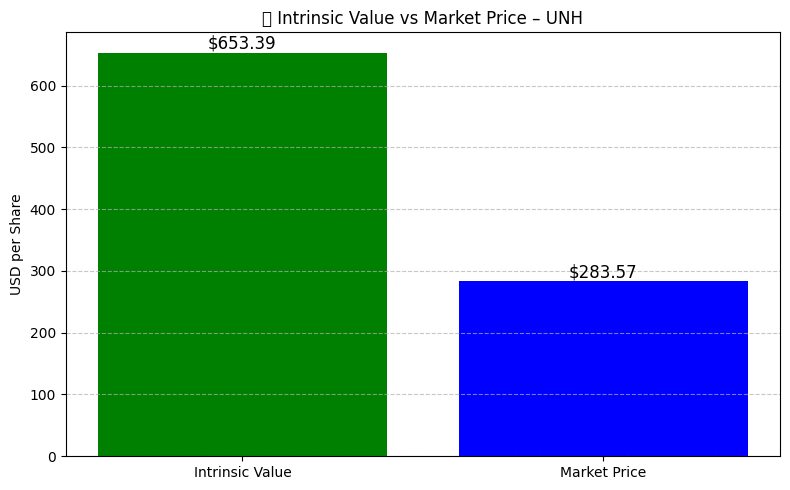

In [190]:
# Create chart
# Data
labels = ['Intrinsic Value', 'Market Price']
values = [value_per_share, price]
colors = ['green', 'blue']

# Create bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color=colors)

# Add labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f"${height:,.2f}", ha='center', va='bottom', fontsize=12)

# Aesthetics
plt.title(f'📊 Intrinsic Value vs Market Price – {ticker.upper()}')
plt.ylabel('USD per Share')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display chart
plt.show()